Epoch [10/100]: 100%|██████████| 938/938 [00:16<00:00, 56.60it/s]


Epoch [10/100], D Loss: 1.3277, G Loss: 0.8618


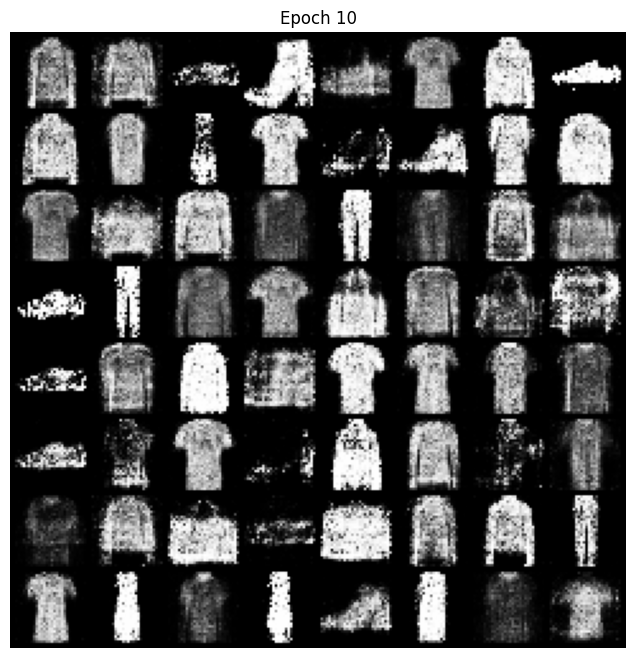

Epoch [20/100]: 100%|██████████| 938/938 [00:16<00:00, 57.36it/s]


Epoch [20/100], D Loss: 1.3672, G Loss: 0.7558


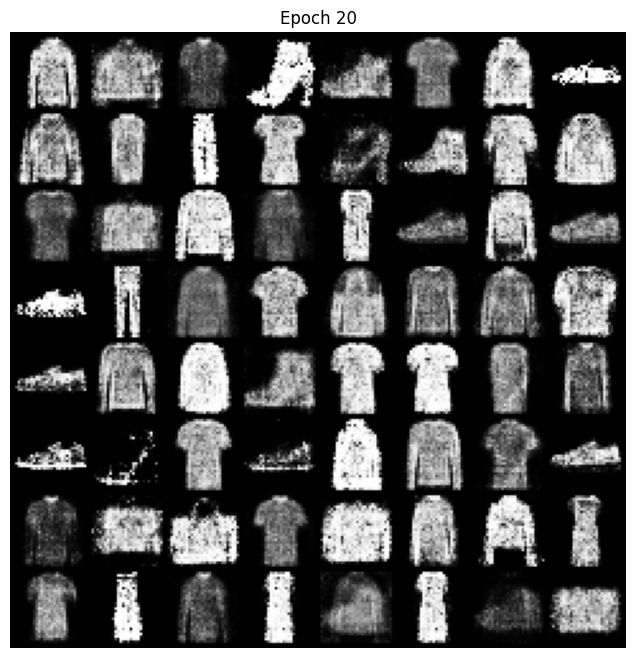

Epoch [30/100]: 100%|██████████| 938/938 [00:16<00:00, 57.31it/s]


Epoch [30/100], D Loss: 1.3757, G Loss: 0.7304


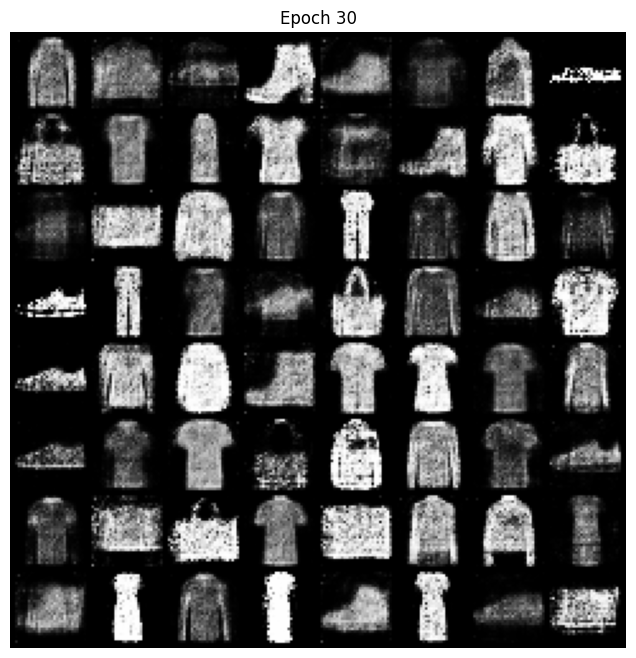

Epoch [40/100]: 100%|██████████| 938/938 [00:16<00:00, 57.56it/s]


Epoch [40/100], D Loss: 1.3797, G Loss: 0.7209


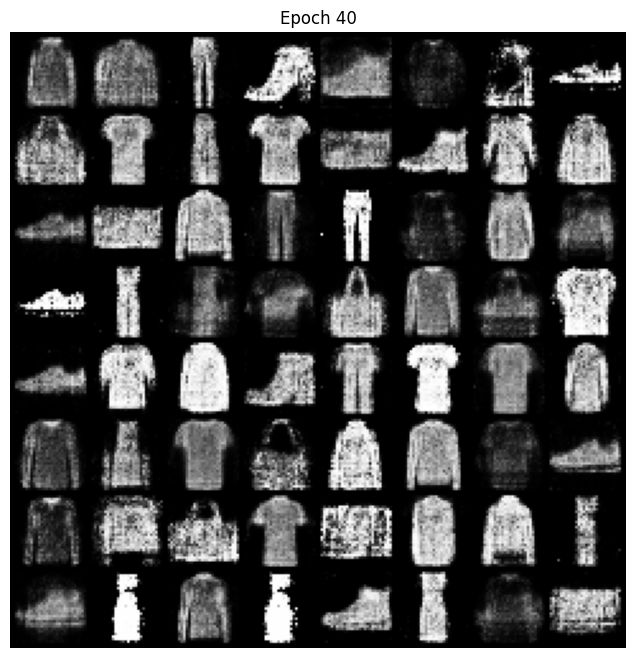

Epoch [50/100]: 100%|██████████| 938/938 [00:16<00:00, 57.10it/s]


Epoch [50/100], D Loss: 1.3816, G Loss: 0.7136


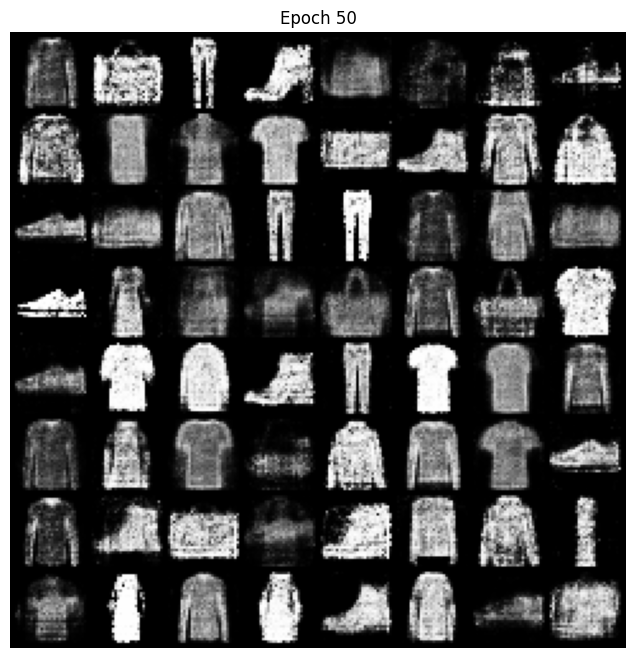

Epoch [60/100]: 100%|██████████| 938/938 [00:16<00:00, 55.86it/s]


Epoch [60/100], D Loss: 1.3837, G Loss: 0.7088


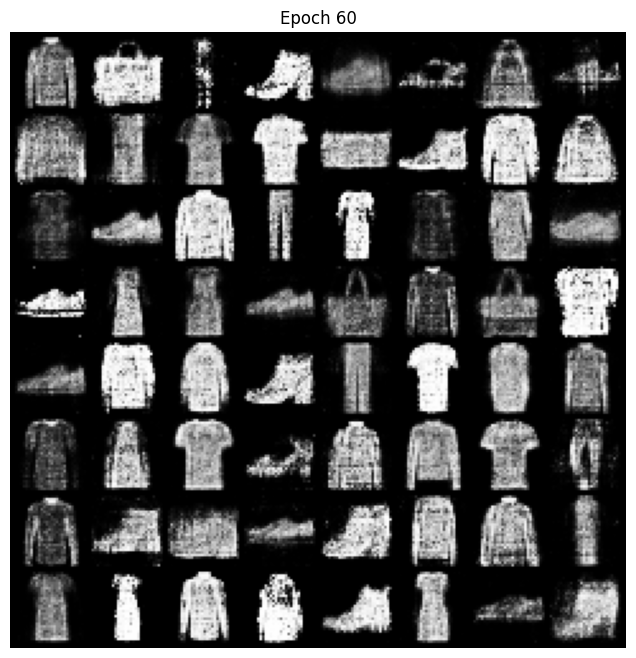

Epoch [70/100]: 100%|██████████| 938/938 [00:16<00:00, 57.30it/s]


Epoch [70/100], D Loss: 1.3824, G Loss: 0.7095


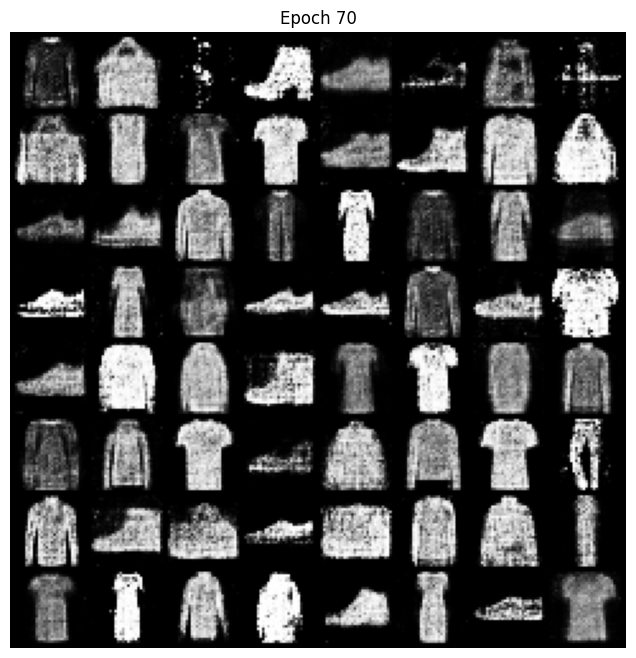

Epoch [80/100]: 100%|██████████| 938/938 [00:16<00:00, 57.49it/s]


Epoch [80/100], D Loss: 1.3842, G Loss: 0.7046


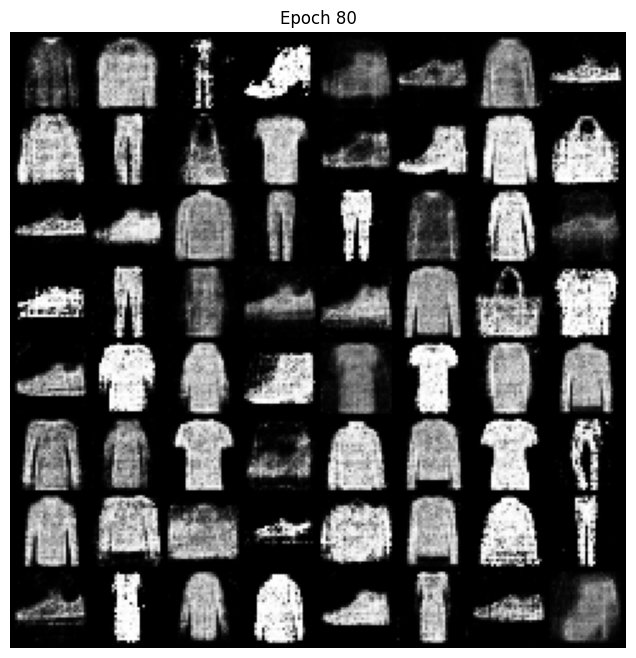

Epoch [90/100]: 100%|██████████| 938/938 [00:16<00:00, 56.75it/s]


Epoch [90/100], D Loss: 1.3842, G Loss: 0.7061


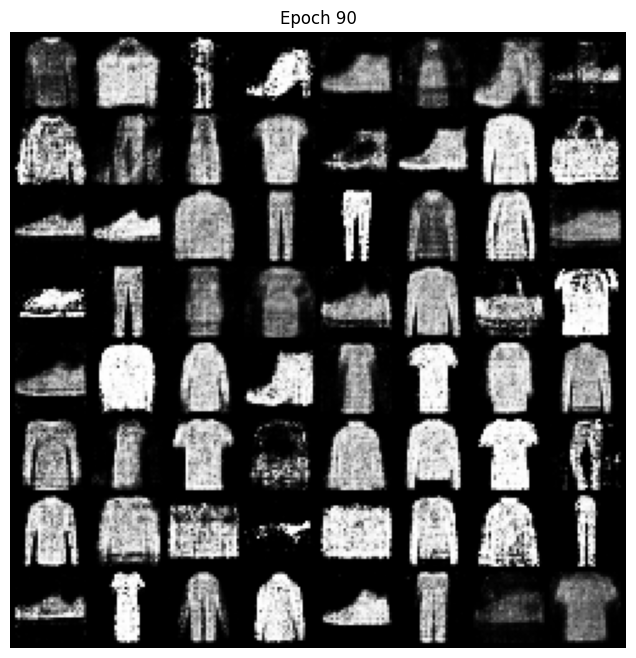

Epoch [100/100]: 100%|██████████| 938/938 [00:16<00:00, 56.77it/s]


Epoch [100/100], D Loss: 1.3847, G Loss: 0.7053


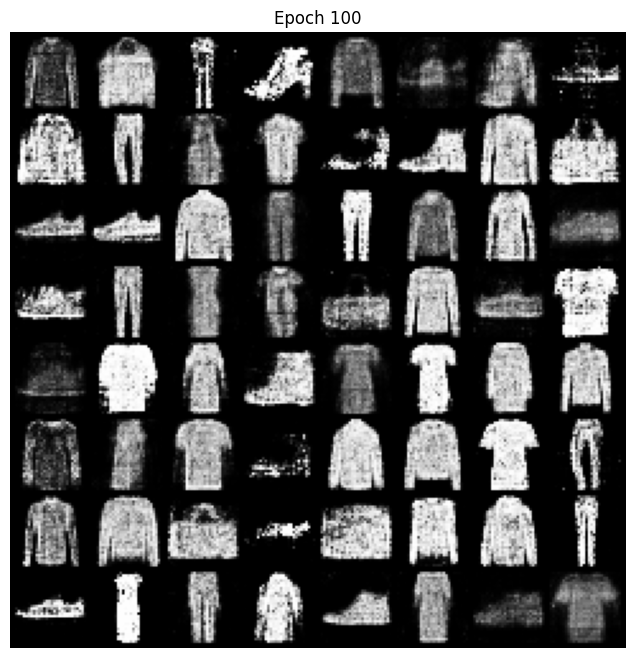

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
batch_size = 64
learning_rate = 0.0002
num_epochs = 100
beta1 = 0.5
log_interval = 10  

writer = SummaryWriter('runs/GAN_experiment')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.model(z)
        return x.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
criterion = nn.BCELoss()

def generate_images(epoch, fixed_noise):
    generator.eval()
    with torch.no_grad():
        generated_images = generator(fixed_noise).cpu()
        grid = make_grid(generated_images, nrow=8, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.title(f'Epoch {epoch}')
        plt.axis('off')
        plt.show()
        writer.add_image('Generated Images', grid, epoch)
    generator.train()

def train():
    fixed_noise = torch.randn(64, latent_dim, device=device)
    for epoch in range(1, num_epochs + 1):
        g_loss_epoch, d_loss_epoch = 0.0, 0.0
        for real_images, _ in tqdm(train_loader, desc=f"Epoch [{epoch}/{num_epochs}]"):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            optimizer_d.zero_grad()
            real_loss = criterion(discriminator(real_images), real_labels)
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(noise)
            fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()
            
            optimizer_g.zero_grad()
            g_loss = criterion(discriminator(fake_images), real_labels)
            g_loss.backward()
            optimizer_g.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

        g_loss_epoch /= len(train_loader)
        d_loss_epoch /= len(train_loader)
        writer.add_scalar('Generator Loss', g_loss_epoch, epoch)
        writer.add_scalar('Discriminator Loss', d_loss_epoch, epoch)

        if epoch % log_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}], D Loss: {d_loss_epoch:.4f}, G Loss: {g_loss_epoch:.4f}")
            generate_images(epoch, fixed_noise)

    writer.close()

train()
